# Ephys Code #

In [20]:
import pyabf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as sp
from scipy.interpolate import CubicSpline, interp1d
from scipy.signal import savgol_filter, find_peaks
from scipy.ndimage import gaussian_filter1d

In [26]:
# load abf
abf = pyabf.ABF("C:/Users/bbyer/OneDrive/Documents/UniversityofKentucky/BachstetterLab/ephys_toolbox/ephys_toolbox/data/2025_03_06_0000.abf")

In [28]:
import pyabf
abf.setSweep(sweepNumber=3)
print(abf.sweepY) # displays sweep data (ADC)
print(abf.sweepX) # displays sweep times (seconds)
print(abf.sweepC) # displays command waveform (DAC)

[1.2207 1.236  1.236  ... 1.2421 1.2726 1.2512]
[0.     0.0001 0.0001 ... 0.0249 0.0249 0.0249]
[0. 0. 0. ... 0. 0. 0.]


In [29]:
sweep_list = abf.sweepList
print(sweep_list)
print(f"Number of traces: {len(sweep_list)}")
num_sweeps = int(input("Enter number of stim sweeps: "))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
Number of traces: 33


In [5]:
sweep_indices = [sweep_list[i:i + num_sweeps] for i in range(0, len(sweep_list), num_sweeps)]

sweep_stims = ["amp25","amp50","amp75","amp100","amp150","amp200","amp250","amp300","amp400","amp500","amp600"]

def build_sweeps(abf, sweep_stims, sweep_indices):
    records = []
    for stim, idxs in zip(sweep_stims, sweep_indices):
        for sweep_id, i in enumerate(idxs, start=1):
            abf.setSweep(i)
            x = abf.sweepX.copy()
            y = abf.sweepY.copy()
            # Flatten into records
            for t, val in zip(x, y):
                records.append((stim, sweep_id, t, val))
    df = pd.DataFrame(records, columns=["stimulus", "sweep", "time", "value"])
    return df

df = build_sweeps(abf, sweep_stims=sweep_stims, sweep_indices=sweep_indices)
display(df)

,stimulus,sweep,time,value
0,amp25,1,0.00000,1.162720
1,amp25,1,0.00005,1.239014
2,amp25,1,0.00010,1.223755
3,amp25,1,0.00015,1.193237
4,amp25,1,0.00020,1.156616
...,...,...,...,...
16495,amp600,3,0.02475,0.762939
16496,amp600,3,0.02480,0.750732
16497,amp600,3,0.02485,0.762939
16498,amp600,3,0.02490,0.765991


In [6]:
def normalize_abf(abf_df):
    df = abf_df.copy()

    # subtract first point of each sweep
    df["t0"] = df.groupby(["stimulus", "sweep"])["value"].transform(lambda x: x.iloc[0])
    df["value"] = df["value"] - df["t0"]

    # reset time per sweep so each starts at 0
    df["time0"] = df.groupby(["stimulus", "sweep"])["time"].transform(lambda x: x.iloc[0])
    df["time"] = df["time"] - df["time0"]

    df.drop(columns=["t0", "time0"], inplace=True)
    return df

normalized = normalize_abf(df)

In [7]:
def remove_stim_artifact(abf_df, pulse_width=0.5e-3, fs=20e3, multiplier=4, std=2.0, K=60):
    """
    Remove stimulation artifact in sweeps using robust MAD detection + local interpolation.

    Parameters
    ----------
    abf_df : DataFrame with columns ["time", "value", "stimulus"]
        LFP sweeps grouped by 'stimulus'.
    pulse_width : float
        Stimulus pulse width (seconds per phase).
    fs : int
        Sampling frequency in Hz.
    multiplier : int
        How many pulse widths forward to mask after onset.
    std : float
        Threshold multiplier for robust MAD (default = 2).
    C: int
        Constant for amp stim removal padding
    """

    def process_group(group):
        g = group.copy()
        x = g["time"].to_numpy()
        y = g["value"].to_numpy()

        # calculate derivative + MAD threshold
        dy = np.gradient(y, x)

        search_window_sec = multiplier * pulse_width
        search_window_samples = int(search_window_sec * fs)

        slope_window = dy[:search_window_samples]
        med_dy = np.median(slope_window)
        mad_dy = np.median(np.abs(slope_window - med_dy))
        T = 1.4826
        thr_dy = std * T * mad_dy

        # detect slope outliers in axis = 0
        outliers = np.where(np.abs(slope_window) > thr_dy)[0]

        if len(outliers) == 0:
            g["clean"] = y
            return g
        
        # artifact bounds
        start_idx = max(1, outliers[0] - 1)
        end_idx   = min(len(x) - 2, outliers[-1] + 1)
       
        stim = g["stimulus"].iloc[0]   # e.g. "amp25"
        amp  = int(stim.replace("amp", ""))
        pad  = int(round(K / np.sqrt(amp)))

        # anchors with ±pad
        lo = max(0, start_idx - pad)
        hi = min(len(x) - 1, end_idx + pad)

        y_fixed = y.copy()
        mask_bad = (x >= x[lo]) & (x <= x[hi])
        
        # linear interpolation
        y_fixed[mask_bad] = np.interp(
            x[mask_bad],
            [x[lo], x[hi]],
            [y[lo], y[hi]]
        )

        g["clean"] = y_fixed
        return g

    return abf_df.groupby("stimulus", group_keys=False)[['stimulus', 'sweep', 'time', 'value']].apply(process_group)

removed = remove_stim_artifact(abf_df=normalized)
display(removed)

,stimulus,sweep,time,value,clean
0,amp25,1,0.00000,0.000000,0.000000
1,amp25,1,0.00005,0.076294,0.003379
2,amp25,1,0.00010,0.061035,0.006757
3,amp25,1,0.00015,0.030518,0.010136
4,amp25,1,0.00020,-0.006104,0.013515
...,...,...,...,...,...
16495,amp600,3,0.02475,-0.167847,-0.167847
16496,amp600,3,0.02480,-0.180054,-0.180054
16497,amp600,3,0.02485,-0.167847,-0.167847
16498,amp600,3,0.02490,-0.164795,-0.164795


In [8]:
def average_traces(abf_df):
    df_summary = (
        abf_df
        .groupby(["stimulus", "time"])
        .agg(
            mean_value=("clean", "mean"),
            sem_value=("clean", lambda x: x.std(ddof=1)/np.sqrt(len(x))) # standard error of the mean, std/sqrt(n)
        )
        .reset_index()
    )
    return df_summary

averaged = average_traces(removed)
display(averaged)

,stimulus,time,mean_value,sem_value
0,amp100,0.00000,0.000000,0.000000
1,amp100,0.00005,-0.001017,0.000000
2,amp100,0.00010,-0.002035,0.000000
3,amp100,0.00015,-0.003052,0.000000
4,amp100,0.00020,-0.004069,0.000000
...,...,...,...,...
5495,amp75,0.02475,0.022380,0.010620
5496,amp75,0.02480,0.014242,0.007121
5497,amp75,0.02485,0.026449,0.007945
5498,amp75,0.02490,0.025431,0.017383


In [9]:
def smooth_curves(abf_df, method="gaussian", win_len=40, poly=2, K=60):
    def process_group(group):
        g = group.copy()
        mean = g["mean_value"].to_numpy()

        if method == "gaussian":
            stim = g["stimulus"].iloc[0]   # e.g. "amp25"
            amp  = int(stim.replace("amp", ""))
            sigma  = int(round(K / np.sqrt(amp)))
            mean_smooth = gaussian_filter1d(mean, sigma=sigma, mode="reflect")
        if method == "savgol":
            mean_smooth = savgol_filter(mean, window_length=win_len, polyorder=poly, mode="interp")
        
        g["mean_smooth"] = mean_smooth

        return g
    
    return abf_df.groupby("stimulus", group_keys=False)[['stimulus', 'time', 'mean_value', 'sem_value']].apply(process_group)
smoothed = smooth_curves(averaged, K=60)
display(smoothed)

,stimulus,time,mean_value,sem_value,mean_smooth
0,amp100,0.00000,0.000000,0.000000,-0.004383
1,amp100,0.00005,-0.001017,0.000000,-0.004517
2,amp100,0.00010,-0.002035,0.000000,-0.004782
3,amp100,0.00015,-0.003052,0.000000,-0.005171
4,amp100,0.00020,-0.004069,0.000000,-0.005673
...,...,...,...,...,...
5495,amp75,0.02475,0.022380,0.010620,0.022019
5496,amp75,0.02480,0.014242,0.007121,0.022228
5497,amp75,0.02485,0.026449,0.007945,0.022395
5498,amp75,0.02490,0.025431,0.017383,0.022511


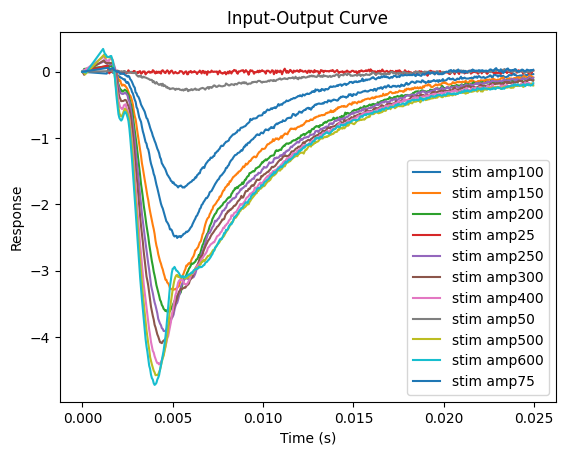

In [10]:
def plot_io_curve(df_summary, raw=False):
    if raw:
        for stim, sub in df_summary.groupby("stimulus"):
            plt.plot(sub["time"], sub["mean_value"], label=f"stim {stim}")
    else:
        for stim, sub in df_summary.groupby("stimulus"):
            plt.plot(sub["time"], sub["mean_smooth"], label=f"stim {stim}")
    plt.title("Input-Output Curve")
    plt.xlabel("Time (s)")
    plt.ylabel("Response")
    plt.legend()
    plt.show()

plot = plot_io_curve(smoothed, raw=True)

Stim amp100: FV start=0.001550s end=0.002100s amp=0.086 mV
Stim amp100: EPSP min=-2.480 mV at 0.005300s
Stim amp100: no PS peak found.


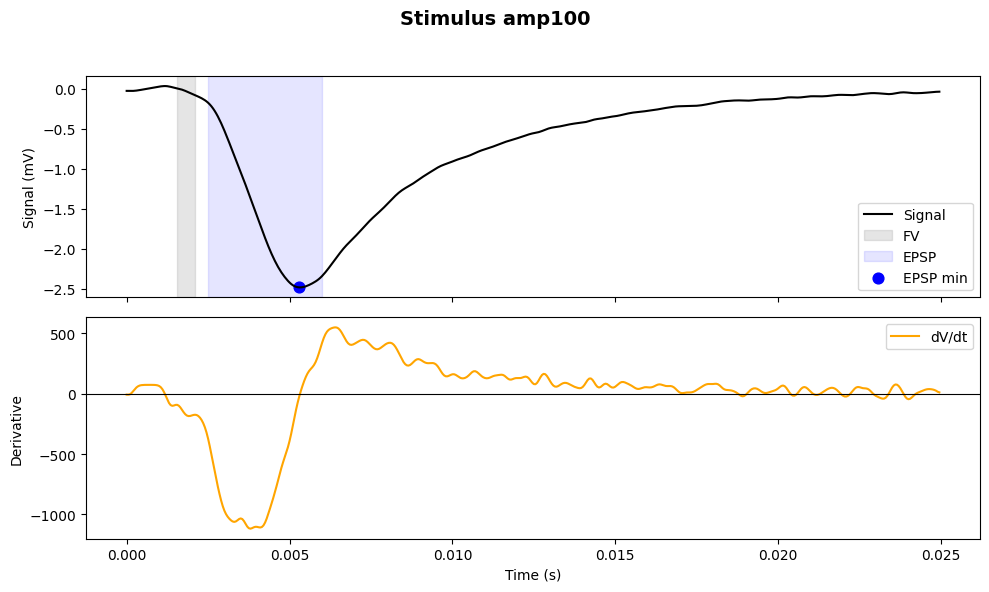

Stim amp150: FV start=0.001600s end=0.002300s amp=0.248 mV
Stim amp150: EPSP min=-3.278 mV at 0.005050s
Stim amp150: no PS peak found.


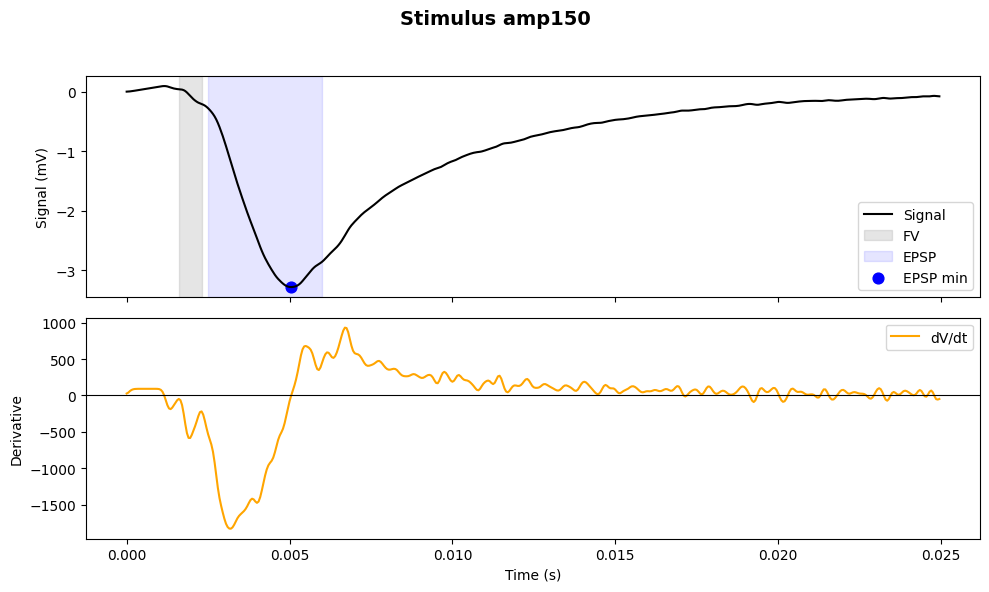

Stim amp200: FV start=0.001500s end=0.002300s amp=0.369 mV
Stim amp200: EPSP min=-3.605 mV at 0.004700s
Stim amp200: no PS peak found.


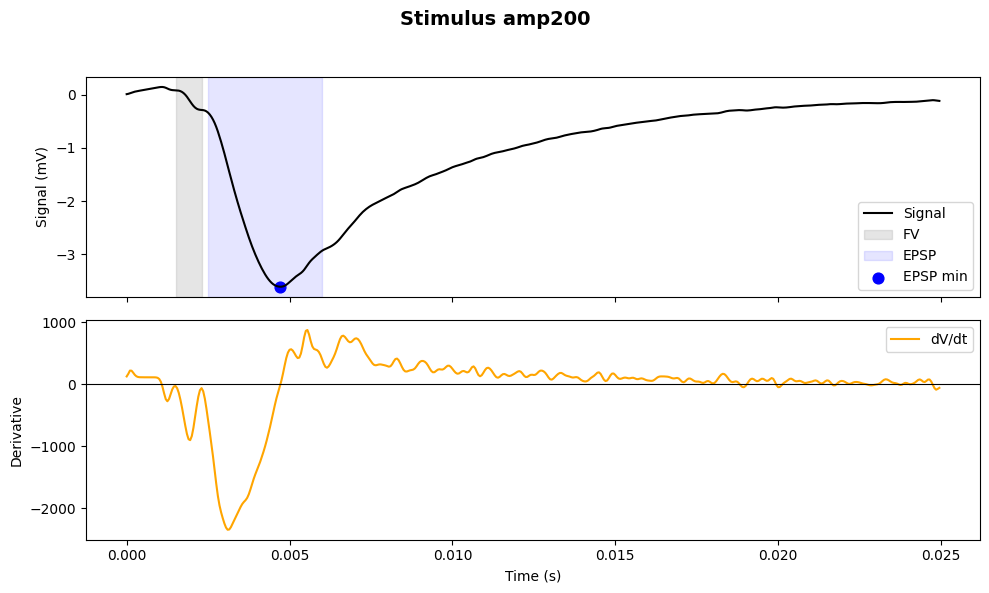

Stim amp25: insufficient FV peaks (1)
Stim amp25: EPSP min=-0.009 mV at 0.005650s
Stim amp25: PS peak at 0.007150s (amp=-0.004 mV)


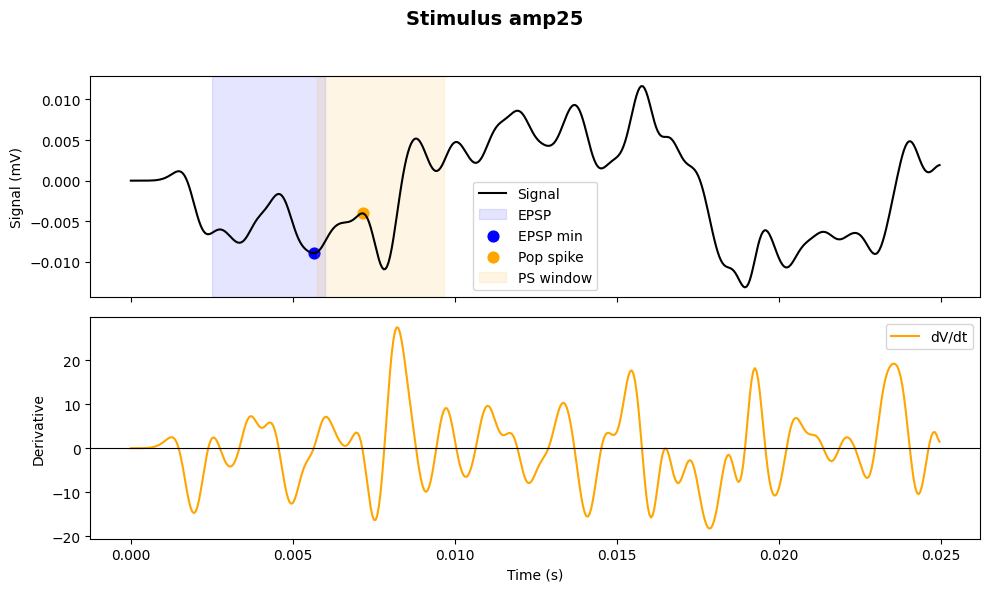

Stim amp250: FV start=0.001500s end=0.002300s amp=0.450 mV
Stim amp250: EPSP min=-3.890 mV at 0.004550s
Stim amp250: no PS peak found.


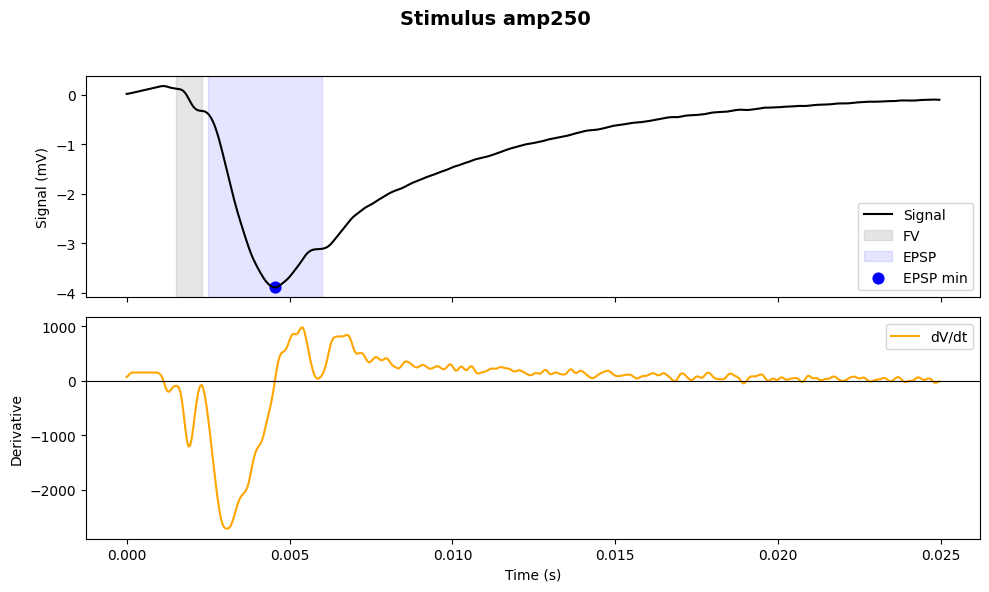

Stim amp300: FV start=0.001450s end=0.002300s amp=0.569 mV
Stim amp300: EPSP min=-4.067 mV at 0.004400s
Stim amp300: no PS peak found.


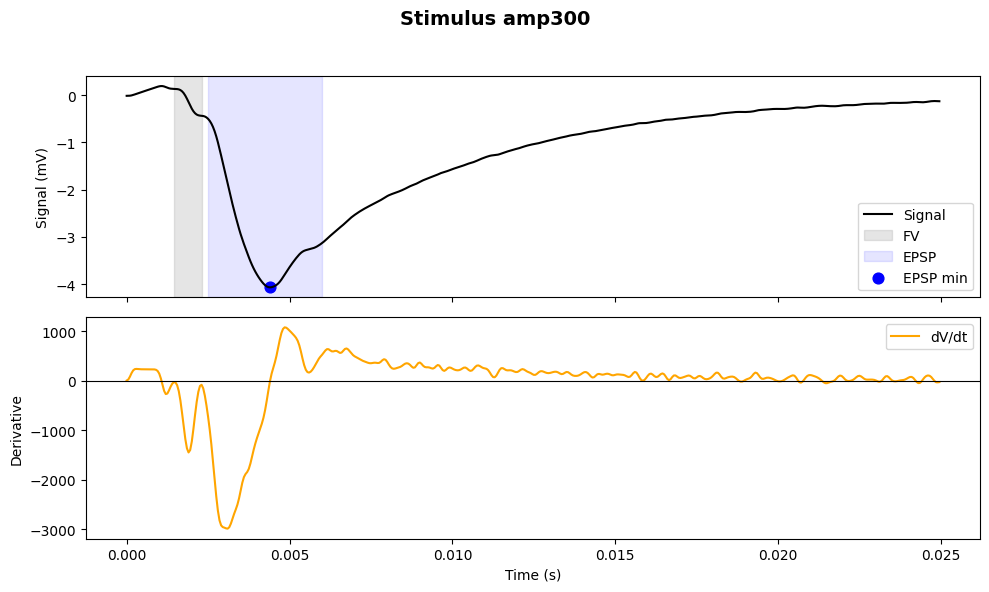

Stim amp400: FV start=0.001450s end=0.002250s amp=0.707 mV
Stim amp400: EPSP min=-4.385 mV at 0.004250s
Stim amp400: PS peak at 0.005500s (amp=-3.154 mV)


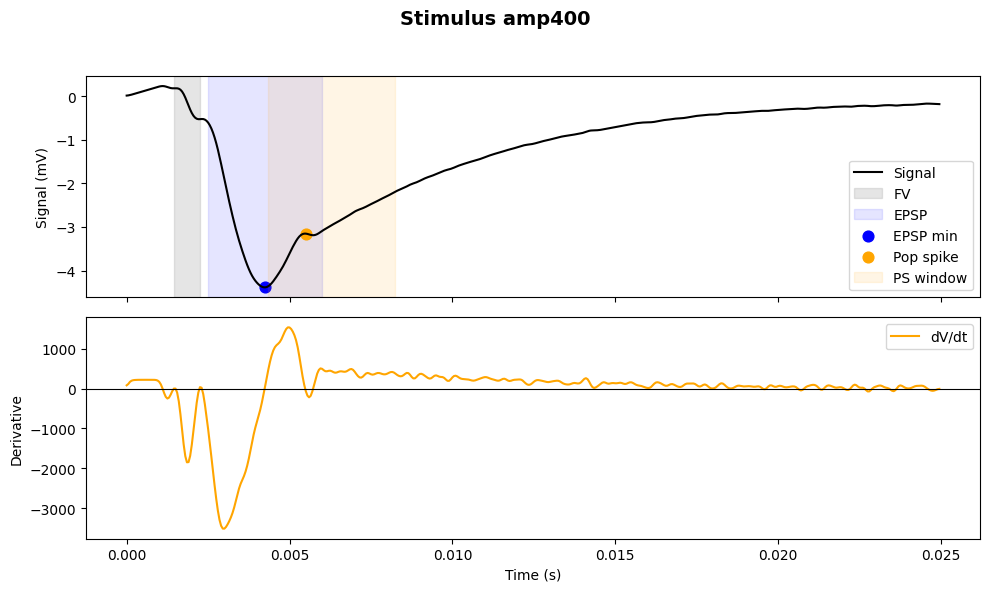

Stim amp50: FV start=0.001100s end=0.002050s amp=0.014 mV
Stim amp50: EPSP min=-0.271 mV at 0.005850s
Stim amp50: PS peak at 0.008900s (amp=-0.171 mV)


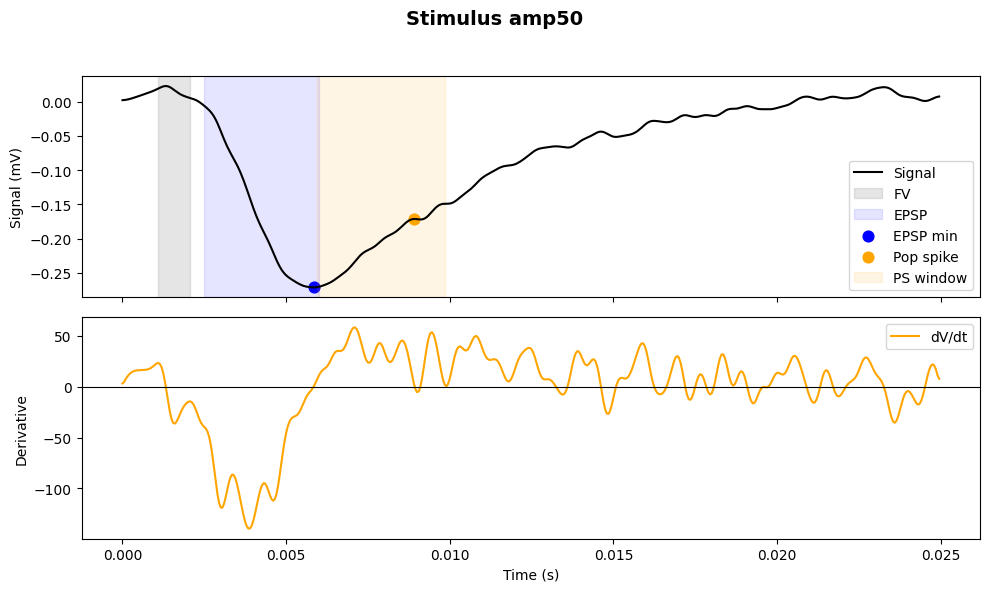

Stim amp500: FV start=0.001400s end=0.002250s amp=0.846 mV
Stim amp500: EPSP min=-4.571 mV at 0.004100s
Stim amp500: PS peak at 0.005250s (amp=-3.076 mV)


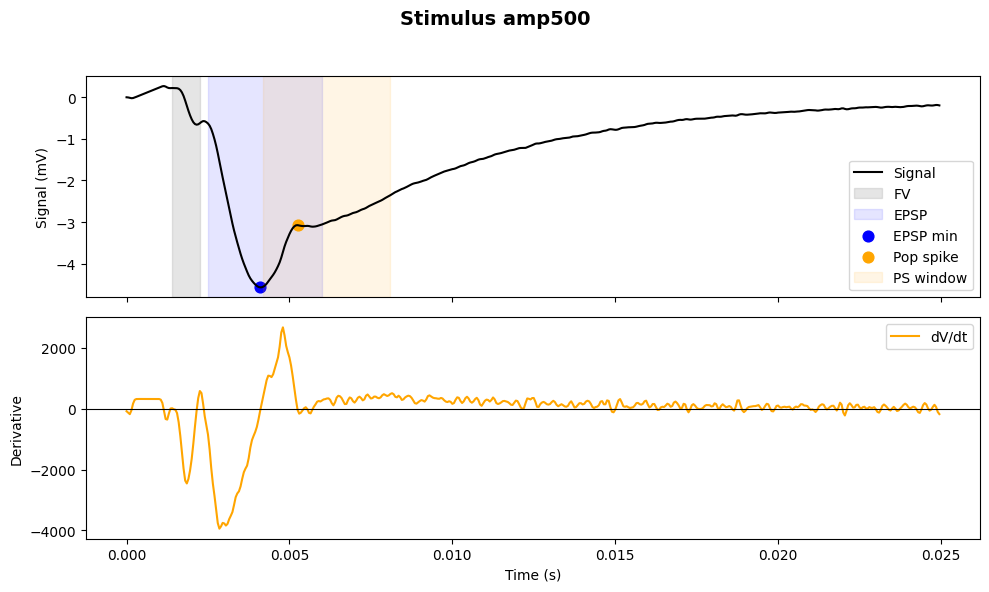

Stim amp600: FV start=0.001500s end=0.002250s amp=0.905 mV
Stim amp600: EPSP min=-4.707 mV at 0.004000s
Stim amp600: PS peak at 0.005100s (amp=-2.960 mV)


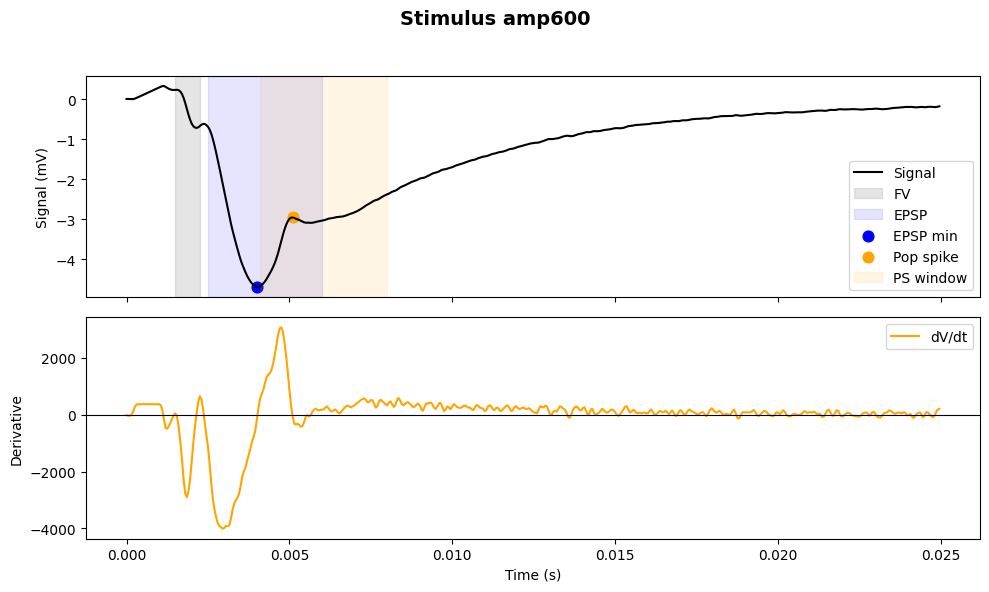

Stim amp75: FV start=0.001600s end=0.002200s amp=0.070 mV
Stim amp75: EPSP min=-1.730 mV at 0.005550s
Stim amp75: no PS peak found.


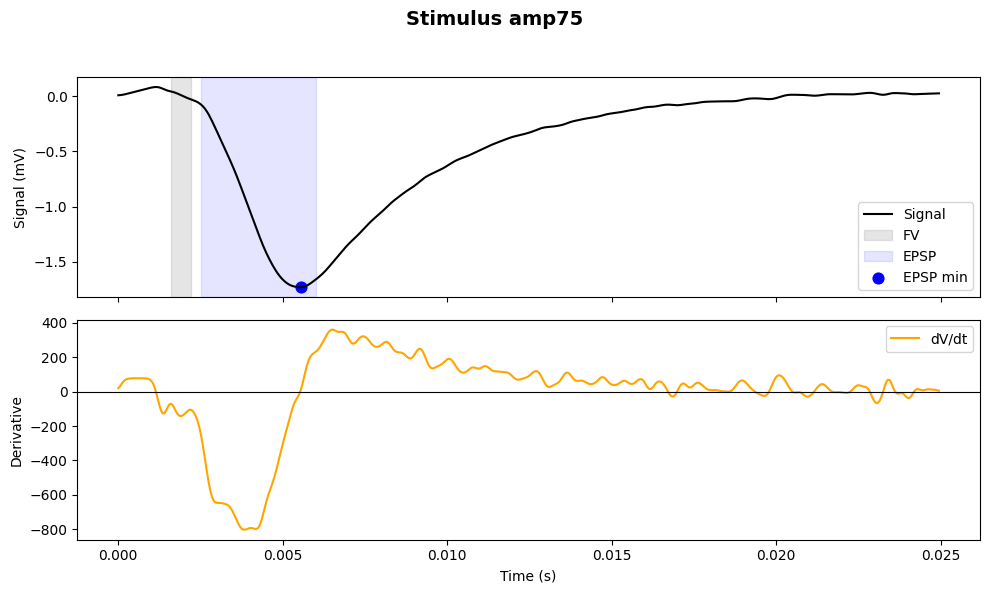


First stimulus with population spike: amp25


C:\Users\bbyer\AppData\Local\Temp\ipykernel_19532\2378195242.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ].apply(process_group)


(     stimulus     time  mean_value  sem_value  mean_smooth  fv_amplitude  \
 0      amp100  0.00000    0.000000   0.000000    -0.029519      0.085513   
 1      amp100  0.00005   -0.045776   0.000000    -0.029875      0.085513   
 2      amp100  0.00010   -0.042089   0.000000    -0.030297      0.085513   
 3      amp100  0.00015   -0.038401   0.000000    -0.030359      0.085513   
 4      amp100  0.00020   -0.034714   0.000000    -0.029709      0.085513   
 ...       ...      ...         ...        ...          ...           ...   
 5495    amp75  0.02475    0.022380   0.010620     0.022981      0.070091   
 5496    amp75  0.02480    0.014242   0.007121     0.023548      0.070091   
 5497    amp75  0.02485    0.026449   0.007945     0.024079      0.070091   
 5498    amp75  0.02490    0.025431   0.017383     0.024519      0.070091   
 5499    amp75  0.02495    0.029500   0.020872     0.024774      0.070091   
 
       epsp_min_time  epsp_min_value  epsp_amplitude  ps_detected  ps_time

In [ ]:
def calculate_fv_epsp_ps(smoothed_df, fs=20e3):
    """
    Compute FV, EPSP, and PS for smoothed LFP data grouped by stimulus intensity.
    - FV: derivative peaks (0.5–2.5 ms)
    - EPSP: minimum voltage (2.5–6 ms)
    - PS: first zero-crossing in derivative (dV/dt = 0) after EPSP min
    """

    def process_group(group):
        g = group.copy()
        stim = group.name
        y = g["mean_smooth"].to_numpy()
        x = g["time"].to_numpy()
        dy = np.gradient(y, x)

        # --- FV ---
        fv_start_search, fv_end_search = 0.5e-3, 2.5e-3
        start_idx, end_idx = int(fv_start_search * fs), int(fv_end_search * fs)
        slope_window = dy[start_idx:end_idx]
        x_window = x[start_idx:end_idx]
        peak_indices, _ = find_peaks(slope_window)

        fv_amp = np.nan
        fv_start = fv_end = None
        fv_min = fv_max = np.nan

        if len(peak_indices) >= 2:
            last_two = peak_indices[-2:]
            fv_start_idx, fv_end_idx = start_idx + last_two[0], start_idx + last_two[1]
            fv_start, fv_end = x[fv_start_idx], x[fv_end_idx]
            fv_max, fv_min = y[fv_start_idx], y[fv_end_idx]
            fv_amp = fv_max - fv_min
            print(f"Stim {stim}: FV start={fv_start:.6f}s end={fv_end:.6f}s amp={fv_amp:.3f} mV")
        else:
            print(f"Stim {stim}: insufficient FV peaks ({len(peak_indices)})")

        # --- EPSP ---
        epsp_start_search, epsp_end_search = 2.5e-3, 6e-3
        epsp_start_idx, epsp_end_idx = int(epsp_start_search * fs), int(epsp_end_search * fs)
        epsp_min_idx = epsp_start_idx + np.argmin(y[epsp_start_idx:epsp_end_idx])
        epsp_min_time, epsp_min_value = x[epsp_min_idx], y[epsp_min_idx]

        epsp_slope_idx = epsp_start_idx + np.argmin(dy[epsp_start_idx:epsp_end_idx])
        epsp_slope_time, epsp_min_slope = x[epsp_slope_idx], dy[epsp_slope_idx]

        epsp_amp = fv_min - epsp_min_value if not np.isnan(fv_min) else np.nan
        print(f"Stim {stim}: EPSP min={epsp_min_value:.3f} mV at {epsp_min_time:.6f}s")

        ps_start_idx = epsp_min_idx + int(0.1e-3 * fs)    # small offset to skip EPSP bottom
        ps_end_idx = min(epsp_min_idx + int(4e-3 * fs), len(y)-1)

        ps_idx = None
        ps_time = np.nan
        ps_value = np.nan
        # Find local maxima (positive peaks) in voltage trace
        peaks, _ = find_peaks(y[ps_start_idx:ps_end_idx])
        if len(peaks) > 0:
            ps_idx = ps_start_idx + peaks[0]
            ps_time = x[ps_idx]
            ps_value = y[ps_idx]
            print(f"Stim {stim}: PS peak at {ps_time:.6f}s (amp={ps_value:.3f} mV)")
        else:
            print(f"Stim {stim}: no PS peak found.")

        # --- Plot ---
        fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
        fig.suptitle(f"Stimulus {stim}", fontsize=14, fontweight='bold')

        axs[0].plot(x, y, 'k', label='Signal')
        if fv_start and fv_end:
            axs[0].axvspan(fv_start, fv_end, color='gray', alpha=0.2, label='FV')
        axs[0].axvspan(x[epsp_start_idx], x[epsp_end_idx], color='blue', alpha=0.1, label='EPSP')
        axs[0].scatter(x[epsp_min_idx], y[epsp_min_idx], color='blue', s=60, label='EPSP min')
        if ps_idx is not None:
            axs[0].scatter(x[ps_idx], y[ps_idx], color='orange', s=60, label='Pop spike')
            axs[0].axvspan(x[ps_start_idx], x[ps_end_idx], color='orange', alpha=0.1, label='PS window')
        axs[0].legend()
        axs[0].set_ylabel('Signal (mV)')

        axs[1].plot(x, dy, color='orange', label='dV/dt')
        axs[1].axhline(0, color='k', linewidth=0.8)
        axs[1].set_xlabel('Time (s)')
        axs[1].set_ylabel('Derivative')
        axs[1].legend()

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

        # --- Store results ---
        g["fv_amplitude"] = fv_amp
        g["epsp_min_time"] = epsp_min_time
        g["epsp_min_value"] = epsp_min_value
        g["epsp_amplitude"] = epsp_amp
        g["ps_detected"] = ps_idx is not None
        g["ps_time"] = ps_time
        g["ps_value"] = ps_value
        return g

    results = smoothed_df.groupby("stimulus", group_keys=False)[
        ['stimulus', 'time', 'mean_value', 'sem_value', 'mean_smooth']
    ].apply(process_group)

    # Find first stimulus with PS detected
    ps_table = results.groupby("stimulus")["ps_detected"].first()
    detected_stims = ps_table[ps_table].index.to_list()
    first_ps_stim = detected_stims[0] if len(detected_stims) > 0 else None
    print(f"\nFirst stimulus with population spike: {first_ps_stim}")
    return results, first_ps_stim

epsp = calculate_fv_epsp_ps(smoothed)
display(epsp)

# TODO:
You need to make the EPSP slope be the slope between EPSP min and maximum
Fiber volley works fine
Population spike code might detect a peak but in the case of amp25 or amp100 it is too small in magnitude. Search literature for the amplitude of population spike.
- Peak based (most stable)
- Deflection based (less stable)
Can you split these into separate functions that work on other curves? Do they depend on each other too much? One mega function sucks
1. Remove stimulus artifact
2. Smooth function
3. Detect fiber volley
4. EPSP slope (slope from start to end, not instantaneous)
5. Population spike detection. Peak or deflection based. Minimum ps amplitude so that PS at 25 microamps is not considered a PS. 0.15 mV? Search literature.

IO curve and output curves from results
Save figures
Save excel file
Make CLI functions
Better file handling